# Bounding boxes

In [ ]:
!pip install tensorflow_io

     |████████████████████████████████| 23.4 MB 1.8 MB/s 


In [ ]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle

## Load data

We will use the test set of the "speech commands" dataset published by Peter Warden in conjunction with the paper [1804.03209](https://arxiv.org/abs/1804.03209).

The training set is located [here](http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz) and the test dataset can be found [here](http://download.tensorflow.org/data/speech_commands_test_set_v0.02.tar.gz).

In [ ]:
dataset_links = {'train_data': 'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz',
                 'test_data': 'http://download.tensorflow.org/data/speech_commands_test_set_v0.02.tar.gz'}

In [ ]:
for key in dataset_links:
    tf.keras.utils.get_file(key+'.tar.gz',
                            dataset_links[key],
                            cache_dir='./',
                            cache_subdir='datasets/'+key,
                            extract=True)

112574464/112563277 [==============================] - 1s 0us/step


In [ ]:
# Perform os.walk to list all the files in our dataset and the
# corresponding labels.

train_data_paths = []
for folder, labels, samples in os.walk('./datasets/train_data/'):
    for sample in samples:
        if sample[-3:] == 'wav':
            train_data_paths.append([folder+'/'+sample, folder[22:]])

In [ ]:
# Convert the list of files and labels to a DataFrame for further
# analysis

df = pd.DataFrame(train_data_paths)
df.head()

,0,1
0,./datasets/train_data/eight/bfd26d6b_nohash_1.wav,eight
1,./datasets/train_data/eight/0585b66d_nohash_3.wav,eight
2,./datasets/train_data/eight/f2898d06_nohash_1.wav,eight
3,./datasets/train_data/eight/36de13e1_nohash_0.wav,eight
4,./datasets/train_data/eight/c634a189_nohash_4.wav,eight


In [ ]:
# Make sure only audio files are listed in our data frame.
all(df[0].apply(lambda row: row[-3:]=='wav'))

True

In [ ]:
# Now we can easily list all the labels
df[1].unique()

array(['eight', 'zero', 'follow', 'on', 'one', 'seven', 'dog', 'yes',
       'cat', 'six', 'house', 'two', 'right', 'three', 'left', 'bird',
       'marvin', '_background_noise_', 'forward', 'four', 'stop',
       'visual', 'learn', 'tree', 'nine', 'off', 'backward', 'five',
       'bed', 'go', 'down', 'sheila', 'up', 'no', 'happy', 'wow'],
      dtype=object)

In [ ]:
# Count the number of samples available per class

for cat in df[1].unique():
    print(cat+" : {}".format((df[1] == cat).sum()))

four : 3728
down : 3917
off : 3745
zero : 4052
one : 3890
nine : 3934
two : 3880
seven : 3998
sheila : 2022
up : 3723
stop : 3872
no : 3941
visual : 1592
backward : 1664
three : 3727
go : 3880
tree : 1759
cat : 2031
dog : 2128
follow : 1579
bird : 2064
wow : 2123
six : 3860
yes : 4044
left : 3801
on : 3845
five : 4052
learn : 1575
house : 2113
marvin : 2100
happy : 2054
eight : 3787
right : 3778
forward : 1557
bed : 2014
_background_noise_ : 6


In [ ]:
# Remove "_background_noise_" recordings from the samples.

df = df.drop(df[df[1] =='_background_noise_'].index)

In [ ]:
df[1].unique()

array(['four', 'down', 'off', 'zero', 'one', 'nine', 'two', 'seven',
       'sheila', 'up', 'stop', 'no', 'visual', 'backward', 'three', 'go',
       'tree', 'cat', 'dog', 'follow', 'bird', 'wow', 'six', 'yes',
       'left', 'on', 'five', 'learn', 'house', 'marvin', 'happy', 'eight',
       'right', 'forward', 'bed'], dtype=object)

In [ ]:
# Vectorize the labels by creating a dictionary as follows:

labels_dict = {df[1].unique()[i]:i for i in range(len(df[1].unique()))}
labels_lookup = {y:x for x,y in labels_dict.items()}

In [ ]:
# Lastly, shuffle the data before we split it into training,
# validation and test sets.
df = df.sample(frac=1)

## Data generator

In [ ]:
# We first need a function to load an audio file as an array.
def load_audio(filepath):
    audio = tfio.audio.AudioIOTensor(filepath)
    audio_rate = int(audio.rate)
    assert audio_rate == 16000
    audio = audio.to_tensor().numpy() / 32767.0
    len = audio.shape[0]
    # Padding
    if len == 16000:
        return audio
    elif len < 16000:
        return np.concatenate([audio, 
                               np.zeros(shape=(16000-len, 1),
                                        dtype="float64")], 
                              axis=0)
    else:
        return audio[0:16000]

There are multiple ways to feed data to a keras model for training, evaluation, or inference. For large datasets that can't be loaded on memory, we have to build a generator.

For image data, "[image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)" is a suitable generator. One can also build a dataset generator and use the "[flow_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory)" option.

For other file formats we can subclass an existing class to import data in batches. We will subclass "Sequence" for our audio data.

In [ ]:
class audio_gen(keras.utils.Sequence):
    def __init__(self, file_paths, labels,
                 batch_size=128, shape=(16000,1),
                 shuffle_on_epoch_end=True):
        # Initialization
        super().__init__()
        self.shape = shape
        self.batch_size = batch_size
        self.labels = labels
        self.paths = file_paths
        self.n_channels = shape[-1]
        self.n_classes = max(labels)+1
        self.shuffle = shuffle_on_epoch_end
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.paths) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[self.batch_size * idx: 
                                 self.batch_size * (idx+1)]
        batch_labels = self.labels[self.batch_size * idx:
                                   self.batch_size * (idx+1)]
        batch_samples = np.zeros(shape=(0, self.shape[0], self.shape[1]), 
                                 dtype='float32')
        for path in batch_paths:
            batch_samples = np.concatenate([batch_samples, [load_audio(path)]], 
                                           axis=0)
        return batch_samples, np.array(batch_labels, dtype='int')

    def on_epoch_end(self):
        # suffle the d
        if self.shuffle:
            self.paths, self.labels = shuffle(self.paths, self.labels)

In [ ]:
len(df)

105829

In [ ]:
# Split the data into training, validation and test datasets.

train_paths = np.array(df[0])[:80000]
train_labels = np.array([labels_dict[x] for x in df[1]])[0:80000]

valid_paths = np.array(df[0])[80000:100000]
valid_labels = np.array([labels_dict[x] for x in df[1]])[80000:100000]

test_paths = np.array(df[0])[100000:]
test_labels = np.array([labels_dict[x] for x in df[1]])[100000:]

In [ ]:
# Build a dataset generator for each dataset.

train_gen = audio_gen(train_paths, train_labels)
valid_gen = audio_gen(valid_paths, valid_labels)
test_gen = audio_gen(test_paths, test_labels)

## Convnet Classifier

Build a simple convnet capable of classifying our 1s long audio samples. Choose the kernel size and strides for each layer to generate reasonable frames over the sample. Starting with a 16000 component vector, we can track which components are "seen" by each branch of the Convnet below.

- Input [0:16000]

- Conv1D [0:128] [64:196] [128:256] ...  (250 frames in total)

- MaxPool [0:196] [128:320] [256:448] ... (125 frames in total)

- Conv1D [0:8192] [4096:12286] ... (4 frames in total)

In [ ]:
n_categories = max(train_labels)+1
inputs = keras.Input(shape=(16000,1))
x = layers.Conv1D(32, 128, strides=64, activation="relu", padding="same")(inputs)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(64, 64, strides=32, activation="relu", padding="same")(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(n_categories, activation="softmax")(x)

model = keras.Model(inputs, x)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 16000, 1)]        0         
                                                                 
 conv1d_6 (Conv1D)           (None, 250, 32)           4128      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 125, 32)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 4, 64)             131136    
                                                                 
 global_average_pooling1d_3   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 35)                2275

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=5,
                                         restore_best_weights=True)

In [147]:
#model.load_weights('./models/speech_recognition_train1.h5')

In [ ]:
model.fit(train_gen, validation_data=valid_gen, validation_steps=1,
          epochs=20, callbacks=callback)

Epoch 1/20
625/625 [==============================] - 518s 828ms/step - loss: 3.0077 - accuracy: 0.1605 - val_loss: 2.7747 - val_accuracy: 0.2891
Epoch 2/20
625/625 [==============================] - 488s 780ms/step - loss: 2.4017 - accuracy: 0.3237 - val_loss: 2.1678 - val_accuracy: 0.3906
Epoch 3/20
625/625 [==============================] - 499s 797ms/step - loss: 2.0331 - accuracy: 0.4366 - val_loss: 2.0769 - val_accuracy: 0.4297
Epoch 4/20
625/625 [==============================] - 495s 792ms/step - loss: 1.8202 - accuracy: 0.5002 - val_loss: 1.8814 - val_accuracy: 0.5078
Epoch 5/20
625/625 [==============================] - 490s 784ms/step - loss: 1.6640 - accuracy: 0.5452 - val_loss: 1.6273 - val_accuracy: 0.5469
Epoch 6/20
625/625 [==============================] - 496s 794ms/step - loss: 1.5425 - accuracy: 0.5770 - val_loss: 1.6117 - val_accuracy: 0.5469
Epoch 7/20
625/625 [==============================] - 493s 788ms/step - loss: 1.4357 - accuracy: 0.6061 - val_loss: 1.6761 -

In [145]:
model.save_weights('./models/speech_recognition_train1.h5')

In [ ]:
model.evaluate(valid_gen)

156/156 [==============================] - 137s 878ms/step - loss: 1.5261 - accuracy: 0.6219


[1.5260803699493408, 0.6219450831413269]

In [ ]:
model.evaluate(test_gen)

45/45 [==============================] - 52s 1s/step - loss: 1.4911 - accuracy: 0.6165


[1.491104006767273, 0.6164930462837219]

## Bounding boxes

With a suitable convnet classifier, we can build a new model that uses the classifier for feature extraction in four 8000-long frames within the sample and classify each frame separately. The frame yielding the highest confidence value is the frame encasing the spoken word within the recording.

In [ ]:
# Build a new model sharing the first few layers with our classifier.
n_categories = max(train_labels)+1
y_inputs = keras.Input(shape=(16000,1))
y = layers.Conv1D(32, 128, strides=64, activation="relu", padding="same")(y_inputs)
y = layers.MaxPooling1D(pool_size=2)(y)
y = layers.Conv1D(64, 64, strides=32, activation="relu", padding="same")(y)

# The output of the last layer is 4 feature representations of the four frames.
# We can feed these 4 representations directly to our classification layer
# instead of applying the MaxPooling layer. 
y = layers.Dense(n_categories, activation="softmax")(y)

# The output of the classification layer is four sets of probability
# distributions over our 35 classes. To select the maximum value in 
# each set we apply the following 2 layers:
y = layers.Permute((2,1))(y)
y = layers.GlobalMaxPooling1D()(y)

# Lastly we apply Softmax to our 4-component output to convert the components
# to probabilities.
y = layers.Softmax()(y)

y_model = keras.Model(y_inputs, y)
y_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 16000, 1)]        0         
                                                                 
 conv1d_32 (Conv1D)          (None, 250, 32)           4128      
                                                                 
 max_pooling1d_23 (MaxPoolin  (None, 125, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_33 (Conv1D)          (None, 4, 64)             131136    
                                                                 
 dense_16 (Dense)            (None, 4, 35)             2275      
                                                                 
 permute_7 (Permute)         (None, 35, 4)             0         
                                                           

In [ ]:
# Set the weights of the new model to be the same as the classifier.

y_model.layers[1].set_weights(model.layers[1].get_weights())
y_model.layers[3].set_weights(model.layers[3].get_weights())
y_model.layers[4].set_weights(model.layers[5].get_weights())

In [160]:
testing_samples = np.zeros(shape=(0, 16000, 1), dtype='float32')
for i in [3,9]:
    testing_samples = np.concatenate([testing_samples, [load_audio(df[0][i])]], axis=0)

In [161]:
y_model.predict(testing_samples)

array([[0.23301356, 0.20124741, 0.2515145 , 0.31422454],
       [0.35097483, 0.28862965, 0.17560355, 0.18479195]], dtype=float32)

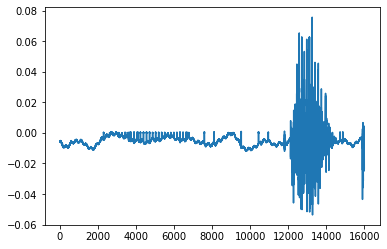

In [162]:
_ = plt.plot(testing_samples[0].reshape(16000))

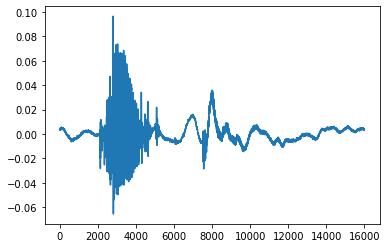

In [156]:
_ = plt.plot(testing_samples[1].reshape(16000))